<a href="https://colab.research.google.com/github/park-ing/A4_Pro_Newspaper-CNN-classificationi/blob/main/A4_%EC%A0%84%EB%8B%A8%EC%A7%80_%EC%8B%A0%EB%AC%B8%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob # 특정 형식 파일 읽기
import random
from PIL import Image
import numpy as np
import tensorflow as tf
import cv2 as cv

In [ ]:
# image list
type0_list = glob('/content/drive/My Drive/A4_pro_news/type0/*.jpg')
type1_list = glob('/content/drive/My Drive/A4_pro_news/type1/*.jpg')
type2_list = glob('/content/drive/My Drive/A4_pro_news/type2/*.jpg')

balance = min(len(type0_list),len(type1_list),len(type2_list))

# image shuffle list
type_0 = []
type_1 = []
type_2 = []

# image shuffle
for i in range(balance):
  type_0.append(type0_list[random.randint(0,len(type0_list)-1)])
  type_1.append(type1_list[random.randint(0,len(type1_list)-1)])
  type_2.append(type2_list[random.randint(0,len(type2_list)-1)])



In [ ]:
def img_lab_to_np(img_list,label_velue,m,n,resize=True):
  img_array = []
  lab_array = []

  for Img in img_list:
    try:
      img = Image.open(Img).convert('RGB') # 이미지를 0~255의 RGB(숫자)값으로 변형해서 불러온다
      if (resize): 
        img = img.resize((m,n))
      img_array.append(np.asarray(img)) #얕은 복사
      lab_array.append(label_velue)
    except:
      continue
  images = np.array(img_array)
  labels = np.array(lab_array)
  return images, labels

In [ ]:
img_type0,lab_type0 = img_lab_to_np(type_0,0,224,224)
img_type0 = img_type0.astype(np.float32)/ 255.  
# 이미지의 픽셀 값을 0.0~1.0 사이의 값으로 정규화(normalize), 0~255의 정수 값을 실수값으로 변경 후 0~1사이의 값이 되도록 255. 으로 나눠줌 (. 이 붙은건 실수값 선언) 
# 신경망을 훈련할 때 32비트 정밀도를 사용하는 것이 가장 일반적(ram때문인가?) 그리고 255로 나누는 것은 기본 학습률이 잘 작동하고 손실값이나 모든 출력값의 편차를 줄이기 위해..
img_type1,lab_type1 = img_lab_to_np(type_1,1,224,224)
img_type1 = img_type1.astype(np.float32)/ 255.

img_type2,lab_type2 = img_lab_to_np(type_1,2,224,224)
img_type2 = img_type2.astype(np.float32)/ 255.

print(img_type0.shape)
class_name = ['A4', 'Promotion','Newspaper']
num_class = len(class_name)

(72, 224, 224, 3)


In [ ]:
# 데이터 불리기
def noisy(noise_typ,image): #노이즈 생성
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
      
   elif noise_typ == "s":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
      out[coords] = 1
      return out

   elif noise_typ =="p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))for i in image.shape]
      out[coords] = 0
      return out

   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals)
      return noisy

   elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy

# 이미지 1장 -> 17장 변환
def make_image_array(IMG,label):
  imagess=[]
  image_label=[]
  #IMG=np.asarray(IMG)
  for i in range(len(IMG)):
    img=IMG[i]
    flipped = tf.image.flip_left_right(img) #좌우반전
    rotated90 = tf.image.rot90(img)         #90도회전
    rotated180 = tf.image.rot90(rotated90)  #180도회전
    rotated270 = tf.image.rot90(rotated180) #270도회전
    
    gauss = noisy('gauss',img)
    s = noisy('s',img)
    p = noisy('p',img)
    speckle = noisy('speckle',img)
    
    # 이미지 중앙만 크롭해서 자르기 () -> 크기
    cropped = tf.image.central_crop(img, central_fraction=0.85)
    cropped1 = tf.image.central_crop(img, central_fraction=0.9)
    cropped2 = tf.image.central_crop(img, central_fraction=0.95)
    # 이미지 채도 계수 증가
    saturated = tf.image.adjust_saturation(img, 3)
    saturated1 = tf.image.adjust_saturation(img, 2)
    # 이미지 밝기 변화
    bright = tf.image.adjust_brightness(img, 0.4)
    bright1 = tf.image.adjust_brightness(img, 0.6)
    bright2 = tf.image.adjust_brightness(img, 0.8)

    m = 224
    n = 224
    # 크롭 이미지 전처리
    cropped=cv.resize(np.float32(cropped),(m,n), interpolation=cv.INTER_AREA)
    cropped1=cv.resize(np.float32(cropped1),(m,n), interpolation=cv.INTER_AREA)
    cropped2=cv.resize(np.float32(cropped2),(m,n), interpolation=cv.INTER_AREA)

    imagess.append(np.float32(img))
    imagess.append(np.float32(flipped))
    imagess.append(np.float32(rotated90))
    imagess.append(np.float32(rotated180))
    imagess.append(np.float32(rotated270))
    imagess.append(np.float32(gauss))
    imagess.append(np.float32(s))
    imagess.append(np.float32(p))
    # imagess.append(poisson)
    imagess.append(np.float32(speckle))
    imagess.append(np.float32(cropped))
    imagess.append(np.float32(cropped1))
    imagess.append(np.float32(cropped2))
    #images.append(grayscaled)
    imagess.append(np.float32(saturated))
    imagess.append(np.float32(saturated1))
    imagess.append(np.float32(bright))
    imagess.append(np.float32(bright1))
    imagess.append(np.float32(bright2))
    
    lab = label[i]
    for j in range(17):
      image_label.append(lab)
  return np.asarray(imagess), np.asarray(image_label)

In [ ]:
from sklearn.utils import shuffle
#이미지를 리스트 하나에 행 방향으로 저장
Meta_image = np.concatenate((img_type0,img_type1,img_type2), axis=0)
Meta_label = np.concatenate((lab_type0,lab_type1,lab_type2), axis=0)

#type별 이미지 다시 shuffle
Meta_image, Meta_label = shuffle(Meta_image, Meta_label)



10747904/10734624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3small (Functional (None, 1000)              2554968   
_________________________________________________________________
dense (Dense)                (None, 500)               500500    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1503      
Total params: 3,056,971
Trainable params: 3,044,859
Non-trainable params: 12,112
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 215, 215, 3)       903       
_________________________________________________________________
max_pooling2d (MaxPo

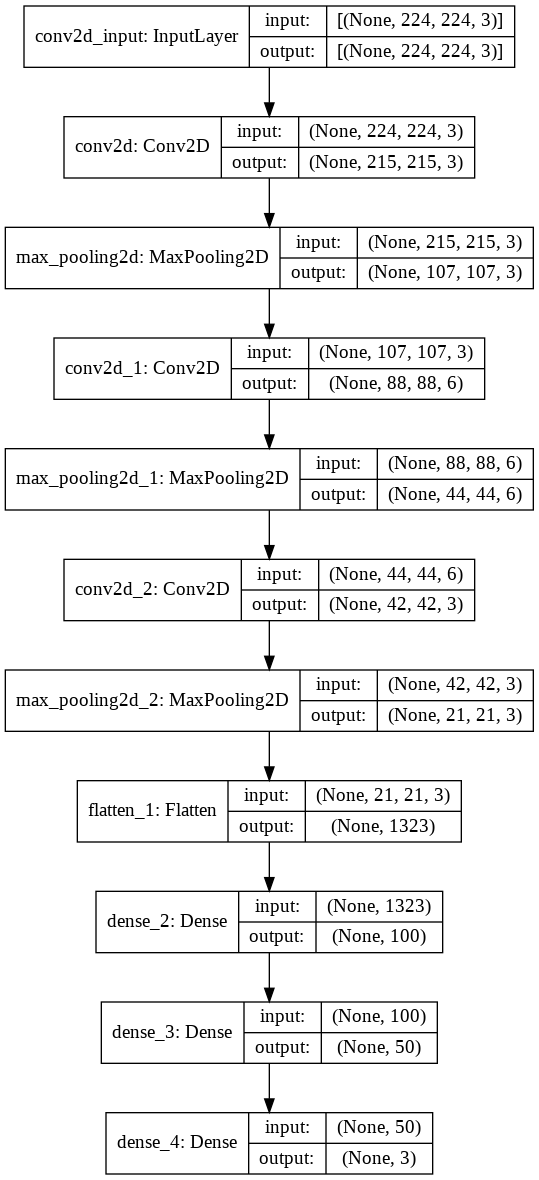

In [ ]:
# model def
#ver1
model = tf.keras.Sequential([
tf.keras.applications.MobileNetV3Small(weights='imagenet',input_shape=(224,224,3),pooling=None,classes=1000),
tf.keras.layers.Dense(500,activation='relu'),
tf.keras.layers.Dense(num_class,activation='softmax',activity_regularizer = tf.keras.regularizers.l1(0.5))
])

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

#ver2
model2 = tf.keras.Sequential([
tf.keras.layers.Conv2D(3,(10,10),input_shape=(224,224,3),activation='linear'),
tf.keras.layers.MaxPool2D((2,2)), #높이2 너비2 사각형 안에서 최대값만 남기는 연산 수행
tf.keras.layers.Conv2D(6,(20,20),input_shape=(107,107,3),activation='swish'),
tf.keras.layers.MaxPool2D((2,2)),
tf.keras.layers.Conv2D(3,(3,3),input_shape=(44,44,6),activation='swish'),
tf.keras.layers.MaxPool2D((2,2)),
tf.keras.layers.Flatten(input_shape=(21,21,3)),
tf.keras.layers.Dense(100,activation='relu'), #완전연결층
tf.keras.layers.Dense(50,activation='relu'),
tf.keras.layers.Dense(num_class,activation='softmax',activity_regularizer = tf.keras.regularizers.l1(0.5))
])
#dropout(rate=0.2) -> 학습과정중에 rate에 지정된 비율반큼 랜덤하게 층(layer)과 층 사이의 연결을 끊어서 네트워크의 과적합을 막는 역할을 수행

# model display
model.summary()
#tf.keras.utils.plot_model(model, show_shapes = True)

model2.summary()
tf.keras.utils.plot_model(model2, show_shapes = True)

In [ ]:
def l_s(initial_learning_rate,step):
  lr = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=5,
      decay_rate=0.99,
      staircase=True)
  return lr

In [ ]:
from numpy.random import seed 
seed(1) # 실행할 때마다 같은 결과를 얻기 위함
from sklearn.model_selection import KFold

Meta_image, Meta_label = shuffle(Meta_image, Meta_label)

# Define per-fold score containers
num_folds = 2

# k-fold Cross Validation model evaluation (교차검증)
kfold = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1

d121_t1=[]
d121_t2=[]
d121_t3=[]
sss=[]
d121_acc_per_fold = []
d121_loss_per_fold = [] 

H = []

for train, test in kfold.split(Meta_image, Meta_label):
  
  
  train_img, train_lab = make_image_array(Meta_image[train],Meta_label[train])
  #shuffle
  train_img, train_lab = shuffle(train_img, train_lab)
  #val
  val_img, val_lab = Meta_image[test][0:int(len(test)/2)],Meta_label[test][0:int(len(test)/2)]
  test_img, test_lab = Meta_image[test][int(len(test)/2):],Meta_label[test][int(len(test)/2):]

  
  S = 50

  L = 1e-5*3
  Opt = tf.keras.optimizers.Adam(learning_rate=l_s(L,S))
  Loss= tf.keras.losses.SparseCategoricalCrossentropy()
  
  model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(3,(10,10),input_shape=(224,224,3),activation='linear'),
  tf.keras.layers.MaxPool2D((2,2)), #높이2 너비2 사각형 안에서 최대값만 남기는 연산 수행
  tf.keras.layers.Conv2D(6,(20,20),input_shape=(107,107,3),activation='swish'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(3,(3,3),input_shape=(44,44,6),activation='swish'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Flatten(input_shape=(21,21,3)),
  tf.keras.layers.Dense(100,activation='relu'), #완전연결층
  tf.keras.layers.Dense(50,activation='relu'),
  tf.keras.layers.Dense(num_class,activation='softmax',activity_regularizer = tf.keras.regularizers.l1(0.5))
  ])
  
  '''
  model = tf.keras.Sequential([
  tf.keras.applications.MobileNetV3Small(weights='imagenet',input_shape=(224,224,3),pooling=None,classes=1000),
  #tf.keras.layers.Dense(500,activation='relu'),
  tf.keras.layers.Dense(num_class,activation='softmax',activity_regularizer = tf.keras.regularizers.l1(0.04))
  # tf.keras.layers.Dense(num_class,activation='softmax')
  ])
  '''
  model.compile(optimizer=Opt,loss=Loss,metrics=['accuracy'])

  model.summary()
  tf.keras.utils.plot_model(model, show_shapes = True)

  print('------------------------------------------------------------------------')
  print(f'Training CNN for fold {fold_no} ...')

  history = model.fit(train_img, train_lab,batch_size=64,epochs=S,verbose=1,validation_data=(val_img,val_lab))
  # verbose = 1(에포크마다 진행막대와 함께 손실 등의 지표가 출력) , 2(진행막대를 빼고 출력함)
  
  H.append(history)
  
  a, b = model.evaluate(test_img,test_lab)
  top1,top2,top3=Top_K_accuracy_for_k_fold(model,test_img, test_lab,3,history)

  model_path = '/content/drive/My Drive/A4_pro_News_model/'+str(fold_no)
  model.save(model_path)
  print(f'CNN Evaluate Score for fold {fold_no}: [{model.metrics_names[0]} of {round(a,3)}], [{model.metrics_names[1]} of {round(b,3)*100}%]')

  fold_no += 1

  d121_acc_per_fold.append(b)
  d121_loss_per_fold.append(a)
  d121_t1.append(top1)
  d121_t2.append(top2)
  d121_t3.append(top3)
  sss.append(Signal_for_k_fold(model.predict(test_img),test_lab))






/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 215, 215, 3)       903       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 107, 107, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 88, 88, 6)         7206      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 44, 44, 6)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 42, 42, 3)         165       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 21, 21, 3)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1323)             

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 215, 215, 3)       903       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 107, 107, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 88, 88, 6)         7206      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 44, 44, 6)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 42, 42, 3)         165       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 21, 21, 3)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1323)             

In [ ]:
  t = []
  t.append(np.sort(train_lab))
  print(t)
  

[array([0, 0, 0, ..., 2, 2, 2])]


In [ ]:
np.sort(train_lab).tolist().count(2)

663

In [ ]:
# == Provide average scores ==
print('--------------Mobile Net V2--------------')
print('각 fold 당 성능')
for i in range(0, len(d121_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> 폴드 {i+1}의 - Loss: {round(d121_loss_per_fold[i],3)} - Accuracy: {round(d121_acc_per_fold[i],3)}%')
print('------------------------------------------------------------------------')
print('모든 폴드들의 평균 성능:')
print(f'> Accuracy: {round(np.mean(d121_acc_per_fold),3)} (+- {round(np.std(d121_acc_per_fold),2)})')
print(f'> Loss: {round(np.mean(d121_loss_per_fold),2)}')
print(f'> class error : {round(np.mean(sss),2)}%')
print(f'> top 1 error : {round(np.mean(d121_t1),2)}%')
print(f'> top 2 error : {round(np.mean(d121_t2),2)}%')
print(f'> top 3 error : {round(np.mean(d121_t3),2)}%')

--------------Mobile Net V2--------------
각 fold 당 성능
------------------------------------------------------------------------
> 폴드 1의 - Loss: 1.434 - Accuracy: 0.463%
------------------------------------------------------------------------
> 폴드 2의 - Loss: 1.314 - Accuracy: 0.574%
------------------------------------------------------------------------
모든 폴드들의 평균 성능:
> Accuracy: 0.519 (+- 0.06)
> Loss: 1.37
> class error : 48.15%
> top 1 error : 48.15%
> top 2 error : 4.65%
> top 3 error : 0.0%


In [ ]:
# function

def Top_K_accuracy_for_k_fold(model,Test_images,Test_labels,j,history):
  top1 = 0.0
  top2 = 0.0
  top3 = 0.0
  # top4 = 0.0
  # top5 = 0.0    
  class_probs = model.predict(Test_images)
  for i, l in enumerate(Test_labels):
      class_prob = class_probs[i]
      
      top_values1 = (-class_prob).argsort()[:1]
      top_values2 = (-class_prob).argsort()[:2]
      top_values3 = (-class_prob).argsort()[:3]
      # top_values4 = (-class_prob).argsort()[:4]
      # top_values5 = (-class_prob).argsort()[:5]
      
      if np.isin(np.array([l]), top_values1):
          top1 += 1.0
      if np.isin(np.array([l]), top_values2):
          top2 += 1.0    
      if np.isin(np.array([l]), top_values3):
          top3 += 1.0
      # if np.isin(np.array([l]), top_values4):
      #     top4 += 1.0    
      # if np.isin(np.array([l]), top_values5):
      #     top5 += 1.0

  TT1=round((1-top1/len(Test_labels))*100,1)
  TT2=round((1-top2/len(Test_labels))*100,1)
  TT3=round((1-top3/len(Test_labels))*100,1)
  # TT4=round((1-top4/len(Test_labels))*100,1)
  # TT5=round((1-top5/len(Test_labels))*100,1)

  return TT1,TT2,TT3

def Signal_for_k_fold(predictions,Test_labels):
  Volume_label=[]
  for i in range(len(predictions)):
    if np.argmax(predictions[i])%3==0:
      Volume_label.append(0)
    if np.argmax(predictions[i])%3==1:
      Volume_label.append(1)
    if np.argmax(predictions[i])%3==2:
      Volume_label.append(2)
    
      
  True_label=[]
  for i in range(len(predictions)):
    if (Test_labels[i])%3==0:
      True_label.append(0)
    if (Test_labels[i])%3==1:
      True_label.append(1)
    if (Test_labels[i])%3==2:
      True_label.append(2)
    
  count =0
  for i in range(len(predictions)):
    if Volume_label[i] == True_label[i]:
      count+=1

  return 100-((count/len(predictions))*100)

def Top_K_accuracy(model,Test_images,Test_labels,j,history):
  top1 = 0.0
  top2 = 0.0
  top3 = 0.0
  top4 = 0.0
  top5 = 0.0    
  class_probs = model.predict(Test_images)
  for i, l in enumerate(Test_labels):
      class_prob = class_probs[i]
      
      top_values1 = (-class_prob).argsort()[:1]
      top_values2 = (-class_prob).argsort()[:2]
      top_values3 = (-class_prob).argsort()[:3]
      top_values4 = (-class_prob).argsort()[:4]
      top_values5 = (-class_prob).argsort()[:5]
      
      if np.isin(np.array([l]), top_values1):
          top1 += 1.0
      if np.isin(np.array([l]), top_values2):
          top2 += 1.0    
      if np.isin(np.array([l]), top_values3):
          top3 += 1.0
      if np.isin(np.array([l]), top_values4):
          top4 += 1.0    
      if np.isin(np.array([l]), top_values5):
          top5 += 1.0

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('{} model accuracy'.format(j),color='w')
  plt.ylabel('accuracy',color='w')
  plt.xlabel('epoch',color='w')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('{} model loss'.format(j),color='w')
  plt.ylabel('loss',color='w')
  plt.xlabel('epoch',color='w')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()
  
  # print(j)
  # print("top1 error", round((1-top1/len(Test_labels))*100,1),'%')
  # print("top2 error", round((1-top2/len(Test_labels))*100,1),'%')
  # print("top3 error", round((1-top3/len(Test_labels))*100,1),'%')
  # print("top4 error", round((1-top4/len(Test_labels))*100,1),'%')
  # print("top5 error", round((1-top5/len(Test_labels))*100,1),'%')
  print('\n')  

def SHOW_ME(model,Test_images,Test_labels):
  predictions = model.predict(Test_images)  
  A,B = Signal(predictions,Test_labels)
  num_rows = 6
  num_cols = 1
  num_images = num_rows*num_cols
  idx = np.random.randint(0,len(Test_labels),size=num_images)
  plt.figure(figsize=(15, 20))

  for i in range(num_images):
    plt.subplot(num_rows, 3*num_cols, 3*i+1)
    plot_image(idx[i], predictions, Test_labels, Test_images)

    if np.argmax(predictions[idx[i]])%3 ==0:
      plt.subplot(num_rows, 3*num_cols, 3*i+2)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      plt.title('Prediction')
      img = cv.imread("PE1.png")
      plt.imshow(img[:,:,::-1])

    if np.argmax(predictions[idx[i]])%3 ==1:
      plt.subplot(num_rows, 3*num_cols, 3*i+2)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      plt.title('Prediction')
      img = cv.imread("PP1.png")
      plt.imshow(img[:,:,::-1])


    if np.argmax(predictions[idx[i]])%3 ==2:
      plt.subplot(num_rows, 3*num_cols, 3*i+2)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      plt.title('Prediction')
      img = cv.imread("PS1.png")
      plt.imshow(img[:,:,::-1])

    plt.subplot(num_rows, 3*num_cols, 3*i+3)
    plot_value_array(idx[i], predictions, Test_labels)
  plt.show()


def Signal(predictions,Test_labels):
  Volume_label=[]
  for i in range(len(predictions)):
    if np.argmax(predictions[i])%3==0:
      Volume_label.append(0)
    if np.argmax(predictions[i])%3==1:
      Volume_label.append(1)
    if np.argmax(predictions[i])%3==2:
      Volume_label.append(2)
    
      
  True_label=[]
  for i in range(len(predictions)):
    if (Test_labels[i])%3==0:
      True_label.append(0)
    if (Test_labels[i])%3==1:
      True_label.append(1)
    if (Test_labels[i])%3==2:
      True_label.append(2)
    
  count =0
  for i in range(len(predictions)):
    if Volume_label[i] == True_label[i]:
      count+=1


  # print('정확도 : {:2.0f}%'.format((count/len(predictions))*100))  
  return Volume_label,True_label

def Results(model,history,Test_images,Test_labels,model_name):
  Top_K_accuracy(model,Test_images,Test_labels,model_name,history)
  SHOW_ME(model,Test_images,Test_labels)


def determine(true_label):
  LAST_label=int(true_label)%5
  if LAST_label==0:
    LAST_label='Paper'
  if LAST_label==1:
    LAST_label='Promotion'

  return LAST_label

def C(t,p):
  if determine(t) == determine(p):
    c='k'
  else:
    c='red'
  return c

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  
  img = cv.flip(img,1)
  rotated90 = tf.image.rot90(img)

  teeee = np.float32(rotated90)
  Rectangle = cv.rectangle(teeee,(7,7),(217,217),(0,255,0),3)
  plt.imshow(Rectangle[:,:,::-1])
  

  predicted_label = np.argmax(predictions_array)
  

  if predicted_label==true_label:
    color = 'k'
  else:
    color = 'red' 
  
  A=predictions_array[0]+predictions_array[3]+predictions_array[6]
  B=predictions_array[1]+predictions_array[4]
  C=predictions_array[2]+predictions_array[5]

  if np.argmax(predictions_array)%3 ==0:
    acc = A
  if np.argmax(predictions_array)%3 ==1:
    acc = B
  if np.argmax(predictions_array)%3 ==2:
    acc = C  
  # plt.title("P : {} {:2.0f}% ( T : {})".format(class_names[predicted_label],
  #                               100*acc,
  #                               class_names[int(true_label)]),color=color, fontsize=9)
  plt.title('Real Image')
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  D=[]
  A=predictions_array[0]+predictions_array[3]+predictions_array[6]
  B=predictions_array[1]+predictions_array[4]
  C=predictions_array[2]+predictions_array[5]
  D.append(A)
  D.append(B)
  D.append(C)
  # thisplot = plt.bar(range(3), D,tick_label=['PE','PP','PS'])
  
  thisplot = plt.bar(range(num_class),predictions_array,tick_label=['PP','PET','PS','HDPE','LDPE'])
  # thisplot.label.set_color('w')
  # plt.xlabel(color = 'w')
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  

  if predicted_label==true_label:
    plt.title("Real & Prediction is : {}  ".format(class_names[true_label]),
                                      color='k', fontsize=12)
  else:
   plt.title("Predictions is : {} but  Real : {}  ".format(class_names[predicted_label],class_names[true_label]),
                                      color='k', fontsize=12)

  
  thisplot[predicted_label].set_color('red')
  thisplot[int(true_label)].set_color('blue')



In [ ]:

test_img[0].shape
print(len(test_img))

54


In [ ]:
from PIL import Image
fpaths = '/content/drive/MyDrive/test_img/pet2.jpg'
m = 224
n = 224
label = 'PET'
img_array = []
lab_array = []

# print(fname)  
img = Image.open(fpaths).convert('RGB')
print(img.size)
img = img.resize((m, n))
print(img.size)
img_array.append(np.asarray(img))
#print(img_array.shape)
lab_array.append(label)

images = np.array(img_array)
labels = np.array(lab_array)

images = images.astype(np.float32) /255.
t = []

preds = model.predict(images)

print(preds)
print(np.argmax(preds))


(640, 360)
(224, 224)
[[0.1419468  0.3332928  0.52476037]]
2


NameError: ignored